## Distributed Computing  Project - Task 2
## Tom Kovalcik
## CDs and Vinyl Amazon Reviews Dataset

### Imports

In [5]:
import pyspark
from pyspark.sql import SparkSession
import json
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from pathlib import Path

### Extract first 5000 lines from original dataset and save as separate file

In [6]:
cat_name = "CDs_and_Vinyl"
sample_size = 5000

data_input_path = Path(f"../../../{cat_name}.jsonl")
data_output_path = Path(f"../../data_samples/{cat_name}_SAMPLE.jsonl")
output_path = f"../../data_samples/{cat_name}_output"

In [7]:
# Extract first 5000 lines of input file and write to output file
with data_input_path.open("r", encoding="utf-8") as file_obj:
    with data_output_path.open("w", encoding="utf-8") as out_file_obj:
        for i, line in enumerate(file_obj):
            if i < sample_size:
                out_file_obj.write(line)
            else:
                break
print(f"{sample_size} lines written to {data_output_path}")

5000 lines written to ../../data_samples/CDs_and_Vinyl_SAMPLE.jsonl


In [8]:
spark = (
    SparkSession.builder
    .appName("CDsAndVinylRDD")
    .master("local[*]")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .getOrCreate()
)

sc = spark.sparkContext

path = str(data_output_path)

raw_rdd = sc.textFile(path)
records_rdd = raw_rdd.map(json.loads)

print("Number of records:", records_rdd.count())
print("First record:", records_rdd.first())

Number of records: 5000
First record: {'rating': 5.0, 'title': 'Five Stars', 'text': 'LOVE IT!', 'images': [], 'asin': 'B002MW50JA', 'parent_asin': 'B002MW50JA', 'user_id': 'AGKASBHYZPGTEPO6LWZPVJWB2BVA', 'timestamp': 1452650777000, 'helpful_vote': 0, 'verified_purchase': True}


In [9]:
def to_year_rating(rec):
    """
    Map each review dict -> (year, (rating_sum, count))
    """
    ts = rec.get("timestamp")
    rating = rec.get("rating")

    if ts is None or rating is None:
        return None

    dt = datetime.utcfromtimestamp(ts / 1000.0)  # ms -> seconds
    year = dt.year

    return (year, (float(rating), 1))


# (1) Map to (year, (rating, 1)) and drop malformed rows
year_rating_pairs = (
    records_rdd
    .map(to_year_rating)
    .filter(lambda x: x is not None)
)

# (2) Aggregate sum of ratings and count per year
#     (year, (sum_ratings, count))
year_agg = year_rating_pairs.reduceByKey(
    lambda a, b: (a[0] + b[0], a[1] + b[1])
)

# (3) Compute (avg_rating, count) per year
#     (year, (avg_rating, count))
year_stats = year_agg.mapValues(lambda s: (s[0] / s[1], s[1]))

# (4) Sort by year and collect
year_results = year_stats.sortByKey().collect()

# Quick sanity check
for year, (avg, cnt) in year_results:
    print(f"{year}: avg_rating={avg:.3f}, count={cnt}")

/var/folders/8q/48hstyms4z79cf6rxhybh5340000gn/T/ipykernel_39889/3615754874.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
/var/folders/8q/48hstyms4z79cf6rxhybh5340000gn/T/ipykernel_39889/3615754874.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).


1998: avg_rating=4.500, count=2
1999: avg_rating=5.000, count=5
2000: avg_rating=4.500, count=14
2001: avg_rating=4.865, count=37
2002: avg_rating=4.756, count=41
2003: avg_rating=4.618, count=34
2004: avg_rating=4.623, count=61
2005: avg_rating=4.353, count=136
2006: avg_rating=4.404, count=156
2007: avg_rating=4.540, count=87
2008: avg_rating=4.367, count=150
2009: avg_rating=4.520, count=75
2010: avg_rating=4.627, count=67
2011: avg_rating=4.539, count=76
2012: avg_rating=4.850, count=227
2013: avg_rating=4.833, count=515
2014: avg_rating=4.685, count=527
2015: avg_rating=4.774, count=605
2016: avg_rating=4.591, count=469
2017: avg_rating=4.728, count=239
2018: avg_rating=4.609, count=297
2019: avg_rating=4.766, count=299
2020: avg_rating=4.677, count=226
2021: avg_rating=4.554, count=316
2022: avg_rating=4.282, count=312
2023: avg_rating=4.519, count=27


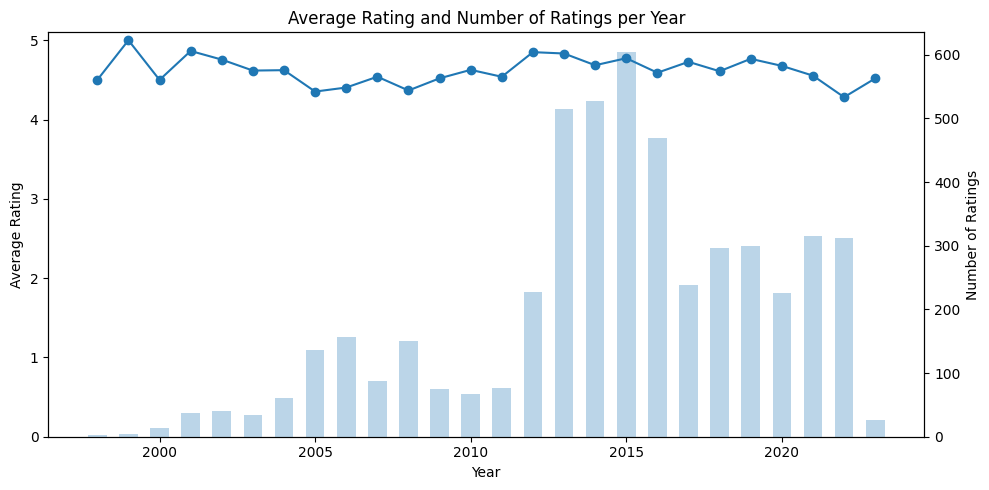

In [10]:
years = [year for year, _ in year_results]
avg_ratings_year = [stats[0] for _, stats in year_results]
counts_year = [stats[1] for _, stats in year_results]

fig, ax1 = plt.subplots(figsize=(10, 5))

# Line: average rating per year
ax1.plot(years, avg_ratings_year, marker="o")
ax1.set_xlabel("Year")
ax1.set_ylabel("Average Rating")
ax1.set_ylim(0, 5.1)
ax1.tick_params(axis="y")

# Second axis for counts (bars)
ax2 = ax1.twinx()
ax2.bar(years, counts_year, alpha=0.3, width=0.6)
ax2.set_ylabel("Number of Ratings")
ax2.tick_params(axis="y")

plt.title("Average Rating and Number of Ratings per Year")
plt.tight_layout()
plt.show()

In [11]:
def save_year_stats(spark, year_results, output_path: str):
    rows = [
        (int(year), float(stats[0]), int(stats[1]))
        for year, stats in year_results
    ]
    df = spark.createDataFrame(rows, ["year", "avg_rating", "num_ratings"])
    (
        df.orderBy("year")
          .coalesce(1)  # optional: fewer output files
          .write
          .mode("overwrite")
          .option("header", True)
          .csv(output_path)
    )

In [12]:
save_year_stats(spark, year_results, output_path)

In [13]:
sc.stop()